# Vulnerability Analysis and Defense Generation using AIShield SDK
* <b>File Name</b>                          : Tutorial_AIShield_Tensorflow_Image_Classification.ipynb
* <b>Date of creation(dd-mm-yyyy)</b>       : 23-12-2022
* <b>Author Name/Dept</b>                   : AIShield
* <b>Organization</b>                       : BGSW
* <b>Description</b>                        : Source Code of Reference Implementation
* <b>Copyright</b>                          : Copyright 2022 Bosch Global Software Technologies Private Limited. All Rights Reserved.

### Input
This Example does the following:
* Downloads the MNIST-Dataset from Tensorflow-Datasets
* Trains a Tensorflow Model for Image Classification on the MNIST Dataset
* Trained Model File : "_mnist_model.h5_"

### Output and Artifacts
1. Vulnerability report
2. Defense report
3. Defense model
4. attack samples

<a target="_blank" href="https://colab.research.google.com/github/bosch-aisecurity-aishield/Reference-Implementations/blob/main/Product_Taskpair_wise/Image_Classification/Extraction/Tutorial_PyPi_AIShield_Image_Classification_Extraction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# # Install AIShield SDK.
# # If not already installed, install by uncommenting the code below

!pip install aishield

# `Prerequisites for Reference Implementation` 

1. Jupyter Notebook
2. Python 3.X
3. matplotlib 3.5.1
4. numpy 1.22.3
5. opencv-python 4.5.5.64
6. pandas 1.4.1
7. scikit-learn 1.0.2
8. tensorflow 2.9.1
9. zipp 3.7.0
10. requests 2.28.0

In [ ]:
"""
Description: commands to install all the packages, Uncomment to install all the libraries. Generally not required for colab environment
Known issue: In colab, if get matplotlib error: cannot import name '_png' from 'matplotlib'. Use !pip install matplotlib==3.1.3
"""
!pip install numpy==1.22
!pip install matplotlib==3.3.4
!pip install tensorflow==2.9.1
!pip install scikit-learn==1.0.2
!pip install humanfriendly==9.2
!pip install tqdm==4.61.1
!pip install requests==2.28.0
!pip install opencv-python

# `1.0 Import Libraries`

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, optimizers , Sequential
from sklearn.model_selection import train_test_split
import zipfile 
import pandas as pd
import cv2
import os
import random
import requests
import json
import time
import shutil

#importing AIShield Library
import aishield as ais

In [ ]:
(X_train,y_train),(X_test,y_test)=datasets.mnist.load_data()

### `Splitting Data into Training and Validation Data` 


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,stratify = y_train,test_size = 0.1,random_state = 42)

### `Checking size of the datasets` 


In [ ]:
print("shape of x_train: ",X_train.shape)
print("shape of y_train: {}".format(y_train.shape))
print(f'shape of x_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')
print(f'shape of x_val: {X_val.shape}')
print(f'shape of y_val: {y_val.shape}')

### `Visualizing few random data samples` 


In [ ]:
def plot(x, y=None, row: int = 2):
    """
    to visualize random sample
    """
    rows = row
    random_indices = random.sample(range(x.shape[0]), rows * rows)
    sample_images = x[random_indices, :]
    if y is not None:
        sample_labels = y[random_indices]

    fig, axs = plt.subplots(nrows=rows, ncols=rows, figsize=(12, 9), sharex=True, sharey=True)
    for i in range(rows * rows):
        subplot_row = i // rows
        subplot_col = i % rows
        axs[subplot_row, subplot_col].imshow(sample_images[i, :])
        if y is not None:
            axs[subplot_row, subplot_col].set_title("Class. %d" % sample_labels[i])
    plt.tight_layout()
    plt.show()

In [ ]:
"""
Description: visualize data
"""
plot(X_train, y_train, row=5)

### `Setting values for Number of Classes and Input Shape` 


In [ ]:
img_row,img_col,channel=28,28,1
num_classes=10
input_shape=(img_row,img_col,channel)

### `Normalizing and Reshaping the Data` 


In [ ]:
X_train = X_train.reshape(-1,*input_shape)/255.0
X_val =  X_val.reshape(-1,*input_shape)/255.0
X_test =  X_test.reshape(-1,*input_shape)/255.0

### `Convert the Labels to one hot encoder` 


In [ ]:
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

# `3.0 Model Development and Training`

In [ ]:
def make_directory(directory):
    """
    Create directory

    Parameters
    ----------
    directorys : list containing the directory's path to create 
    
    Returns
    -------
    None.

    """
    for d in directory:
        if os.path.isdir(d):
            print("directory {} already exist".format(d))
        if os.path.isdir(d)==False:
            os.mkdir(path=d)
            print("directory {} created successfully".format(d))

In [ ]:
def delete_directory(directorys):
    """
    Delete directory 

    Parameters
    ----------
    directorys : list containing the directory's path to delete along with all the files

    Returns
    -------
    None.

    """
    if len(directorys)>=1:
        for d in directorys:
            if os.path.isdir(d):
                try:
                    if os.path.isfile(d):
                        os.remove(path=d)
                    else:
                        shutil.rmtree(path=d)
                        print("Removed: {}".format(d))
                except:
                    print("Failed to removed: {}".format(d))
            else:
                print("Failed to removed: {}".format(d))
                

In [ ]:
def make_archive(base_name,root_dir,zip_format='zip'):
    """
    Creates zip for given folder

    Parameters
    ----------
    base_name : name of zip file
    root_dir : directory to archive/zip
    zip_format : zip or tar 
        DESCRIPTION. The default is 'zip'.

    Returns
    -------
    None.

    """
    shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir)
    

### `Creating Data, Model and Label Folder` 


In [ ]:
data_path=os.path.join(os.getcwd(),"data")
model_path=os.path.join(os.getcwd(),"model")
label_path=os.path.join(os.getcwd(),"label")

#Create Zip Path which contains data , model and label zip files
zip_path=os.path.join(os.getcwd(),"zip2")

#deleting previously generated folders
delete_directory(directorys=[data_path,model_path,label_path,zip_path])

#creating folders
make_directory([data_path,model_path,label_path,zip_path])

### `Creating the Model Architecture` 


In [ ]:
"""
Description: Create model architecture
"""
model = Sequential([
    layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPool2D(strides=(2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  
])

#Compile model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
"""
Description: Model summary
"""
model.summary()

In [ ]:
"""
Description : Callbacks
"""
# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_path,'mnist_model.h5'),monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
# Early stopper
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=3,mode='min')

callbacks = [early_stop, checkpoint]

### `Training and Evaluating the Model` 


In [ ]:
"""
Description: Training model
"""
history = model.fit(X_train, y_train, validation_data = (X_test, y_test),epochs = 1, batch_size=64, verbose = 1 , callbacks = callbacks)

In [ ]:
"""
Description: Evaluate trained model
"""
loss,accuracy=model.evaluate(X_test, y_test)
print("* Loss: {} \n* Accuracy: {}".format(loss,accuracy))

# `4.0 Prepare Data , Model and Label`

In [ ]:
"""
Description: Save data and label
"""
label=pd.DataFrame()
img_name = []
img_label = [] 
  
for i in range(X_val.shape[0]):
    cv2.imwrite(os.path.join(data_path,str(i)+".jpg") ,X_val[i]*255.0) # don't use plt.imread otheriwse while loading the saved images , and passing to model there is accuarcy drop 
    img_name.append(str(i)+".jpg")
    img_label.append(y_val[i])
label['image'] = img_name
label["label"] = np.array(img_label)

#write orig_label dataframe
label.to_csv(os.path.join(label_path,"label.csv"),index=False)

### `Creating Zip Folders of Data, Label and Model`

In [ ]:
"""
Description: Zip data
"""
make_archive(base_name=os.path.join(zip_path,"data"),root_dir=data_path,zip_format='zip')

"""
Description: Zip label
"""
make_archive(base_name=os.path.join(zip_path,"label"),root_dir=label_path,zip_format='zip')

"""
Description: Zip model
"""
model_encryption=0 #0 if model is uploaded directly as a zip, 1 if model is encryted as .pyc and uploaded as a zip
if os.path.isfile(os.path.join(zip_path,"model.zip")):
    delete_directory(directorys=[os.path.join(zip_path,"model.zip")])
make_archive(base_name=os.path.join(zip_path,"model"),root_dir=model_path,zip_format='zip')

# `5.0 Vulnerability Analysis and Defense Generation using AIShield SDK`

In [ ]:
"""
Description: AIShield API URL and subscription key
""" 
baseurl="" # fill in API endpoint url from AIShield developer portal under API tab 
url = baseurl+" "
api_key = " " # fill in subscription key from AIShield developer portal under My Dashboard tab
org_id = " " # fill in Org_Id provided in welcome email

In [ ]:
"""
Description: File paths
"""
data_path=os.path.join(zip_path,'data.zip') #full path of data zip
label_path=os.path.join(zip_path,'label.zip') #full path of label zip
model_path=os.path.join(zip_path,'model.zip') #full path of model zip

### `Perform Vulnerability Analysis through VulConfig Function`

In [ ]:
"""
Description: Initialize the AIShield API
"""
client = ais.AIShieldApi(api_url=url, api_key=api_key, org_id=org_id)

In [ ]:
"""
Description: Define the task and analysis type
"""
task_type = ais.get_type("task", "image_classification")
analysis_type = ais.get_type("analysis", "extraction")

In [ ]:
"""
Description: Perform model registration and upload the input artifacts
"""
status, job_details = client.register_model(task_type=task_type, analysis_type=analysis_type)
model_id = job_details.model_id
# print('Model id: {} \nInput artifacts will be uploaded as:\n data_upload_uri: {}\n label_upload_uri: {}'
#       '\n model_upload_uri: {}'.format(model_id, job_details.data_upload_uri, job_details.label_upload_uri,
#                                        job_details.model_upload_uri))

upload_status = client.upload_input_artifacts(job_details=job_details,
                                              data_path=data_path,
                                              label_path=label_path,
                                              model_path=model_path, )
print('Upload status: {}'.format(', '.join(upload_status)))

In [ ]:
"""
Description: Specify the appropriate configs required for vulnerability analysis
"""

vuln_config = ais.VulnConfig(task_type=task_type,
                             analysis_type=analysis_type,
                             defense_generate=True)

vuln_config.input_dimensions = input_shape  # input dimension for mnist digit classification
vuln_config.number_of_classes = num_classes  # number of classes for mnist digit classification
vuln_config.attack_type = "greybox"  # greybox or blackbox depending upon the availability of information about Model, Data and Parameters
vuln_config.number_of_attack_queries = 60000  # Number of attack queries to be generated for testing model vulnerability 
vuln_config.encryption_strategy = 0  # value 0 (or) 1, if model is unencrypted or encrypted(pyc) respectively
print('IC-Extraction parameters are: \n {} '.format(vuln_config.get_all_params()))

In [ ]:
"""
Description: Run vulnerability analysis
"""
my_status, job_details = client.vuln_analysis(model_id=model_id, vuln_config=vuln_config)
my_job_id = job_details.job_id
print('status: {} \nJob_id: {} '.format(my_status, my_job_id))

In [ ]:
"""
Description: Monitor progress for given Job ID using the Link below
"""
print('Click on the URL to view Vulnerability Dashboard (GUI): {}'.format(job_details.job_monitor_uri))

In [ ]:
"""
Description: Fetch Job status using Job ID
"""
my_status = client.job_status (job_id = my_job_id)
print('job status ', my_status)

### `Saving the Artifacts and the Reports`

In [ ]:
"""
Description: Creating a directory to save the defense artifacts
"""
OUTPUT_PATH = os.path.join(os.getcwd(),"Output_Artifacts")
make_directory([OUTPUT_PATH])

In [ ]:
"""
Description: Download the Vulnerability Report
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "vulnerability"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    vul_report_path = client.save_job_report(job_id=my_job_id, output_config=output_conf)

In [ ]:
"""
Description: Download the Defense Reports
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "defense"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    def_report_path = client.save_job_report(job_id=my_job_id, output_config=output_conf)

In [ ]:
"""
Description: Download the Defense artifacts: Model
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "defense_artifact"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    def_model_path = client.save_job_report(job_id=my_job_id, output_config=output_conf)

In [ ]:
"""
Description: Download the Attack Samples
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "attack_samples"),
                                 save_folder_path=OUTPUT_PATH)
        
    attack_samples_path = client.save_job_report(job_id=my_job_id, output_config=output_conf)

## Defense Model Simulation

In [ ]:
def zip_extractor(file, extract_path=None, delete_zip=False):
    """
    extract zip file to the given path

    Parameters
    ----------
    file : path of zip file
    extract_path : path to extract zip file, default considered parent directory
    delete_zip: True, delete zip file after unzipping it

    Returns
    -------
    None.
    """
    if extract_path is None:
        extract_path = os.path.dirname(file)
    print("Extracting : {}".format(file))
    zf = zipfile.ZipFile(file=file, mode='r')
    zf.extractall(extract_path)
    zf.close()
    if delete_zip:
        os.remove(file)
        print("{} removed successfully.".format(file))

def get_file_path(path):
    """
    To get full file path from directory and child directory
    Args:
        path: Directory path

    Returns: list containing full path of all the file from the given directory

    """
    list_id = []
    for (root, dirs, files) in os.walk(path, topdown=True):
        if len(dirs) == 0:
            for file in files:
                list_id.append(os.path.join(root, file))
    return list_id
    

def load_data(path):
    """
    path: load data from given path
    """
    files_path = get_file_path(path)
    x = []
    for file in files_path:
        img = cv2.imread(file, 0)
        x.append(img)
    x = np.expand_dims(np.array(x), axis=-1)
    return x

In [ ]:
"""
Description: extract attack sample
"""
sample_data = os.path.join(OUTPUT_PATH, 'sample_data')
zip_extractor(file=attack_samples_path, extract_path=sample_data)

In [ ]:
"""
Description: load attack data
"""
x_attack = load_data(path=sample_data)
plot(x=x_attack, row=4)

In [ ]:
"""
Description: Extracting defense artifact
"""
zip_extractor(file=def_model_path)

In [ ]:
"""
Description: Load defense model
"""
defense_model_path = os.path.join(OUTPUT_PATH, 'defense_model.h5')
defense_model = tf.keras.models.load_model(defense_model_path)

In [ ]:
"""
Description: Pass original data to get prediction
"""
label , prob = defense.predict(X_val[:5])
print("\nlabel: {} \nprob: {}".format(label, prob))

In [ ]:
"""
Description: Pass sample attack data to get prediction
"""
label , prob = defense.predict(x_attack[:5])
print("\nlabel: {} \nprob: {}".format(label, prob))

## `Convert Applicatoin Model & Defense Model to TFLite`

In [ ]:
# Model Path 
directory = make_directory([os.path.join(os.getcwd(),"tflite_model")])
converted_model_path = os.path.join(os.getcwd(), "tflite_model")

# Converting Application Model to TFLite 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(converted_model_path+"/application.tflite", "wb").write(tflite_model)

# Converting Defense Model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(defense_model)
tflite_model = converter.convert()
open(converted_model_path+"/defense.tflite", "wb").write(tflite_model)

### `Copy Files to GreenGrass Deployment Folder`

In [ ]:
def copy_files(src_folder, dst_folder, dst_subfolder=None,file_names=None):
    
    """""
    Arguments to pass:
    src_folder = Source folder from where to copy files
    dst_folder = Destination folder 
    dst_subfolder = Copies the files to a specified destination folder if mentioned, default is dst_folder
    file_names = Give the file name to copy, default: "None" copies all the fiels available in the folder
    """""

    if file_names is None:
        # if file_names is None, copy all files in the source folder
        files = os.listdir(src_folder)
    else:
        # if file_names is specified, copy only those files
        files = [file_names]
    
    if dst_subfolder is not None:
        # if a subfolder is specified, create it in the destination folder
        dst_folder = os.path.join(dst_folder, dst_subfolder)
        os.makedirs(dst_folder, exist_ok=True)
        
    # iterate over the list of files and copy them
    for file_name in files:
        src_file_path = os.path.join(src_folder, file_name)
        dst_file_path = os.path.join(dst_folder, file_name)
        shutil.copy(src_file_path, dst_file_path)
    return print("Files Copied Successfully")

In [ ]:
# navigate a folder back from the current directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Description: Copy TFLite Models to gg_deployment folder in application and defense folder which will be useful to create artifacts for Green Grass Component  

dst_path = os.path.join(parent_dir, "gg_deployment")
copy_files(converted_model_path, dst_path, "application/", "application.tflite")
copy_files(converted_model_path, dst_path, "defense/", "defense.tflite")

## Experimentation Report

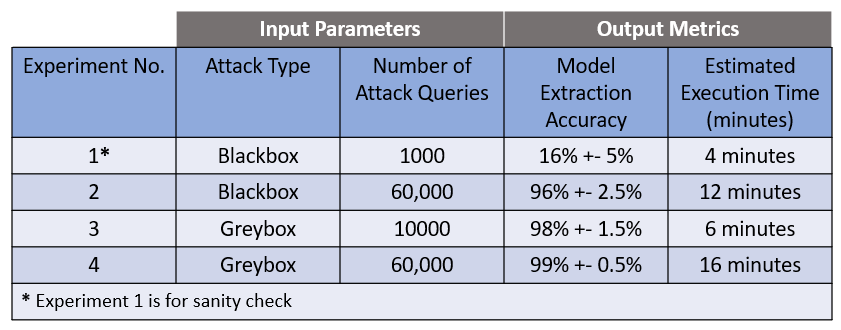